In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

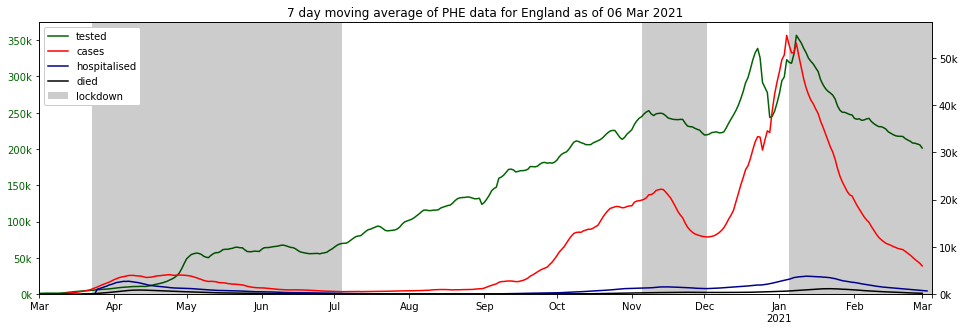

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum,),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

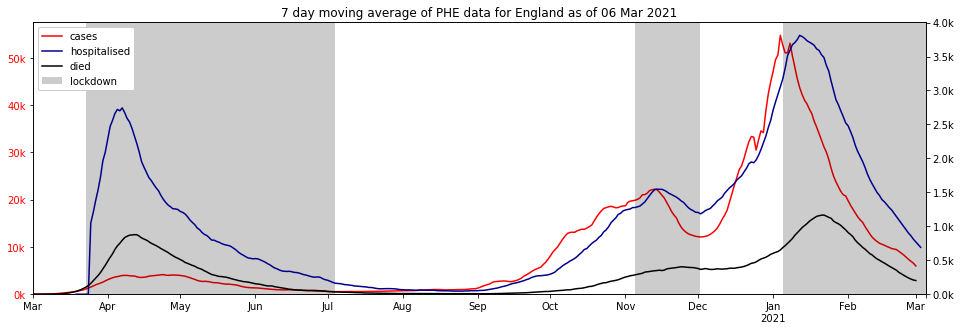

In [3]:
plot_summary(left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,766500.0,18491771.0,17725271.0,56286961,1.361772,31.490901,67.147327
1,Northern Ireland,N92000002,42096.0,577219.0,535123.0,1893667,2.222989,28.258559,69.518453
2,Scotland,S92000003,114081.0,1743869.0,1629788.0,5463300,2.088134,29.831567,68.080299
3,Wales,W92000004,168163.0,983419.0,815256.0,3152879,5.333633,25.857510,68.808857


'partial: 21,796,278, full: 1,090,840'

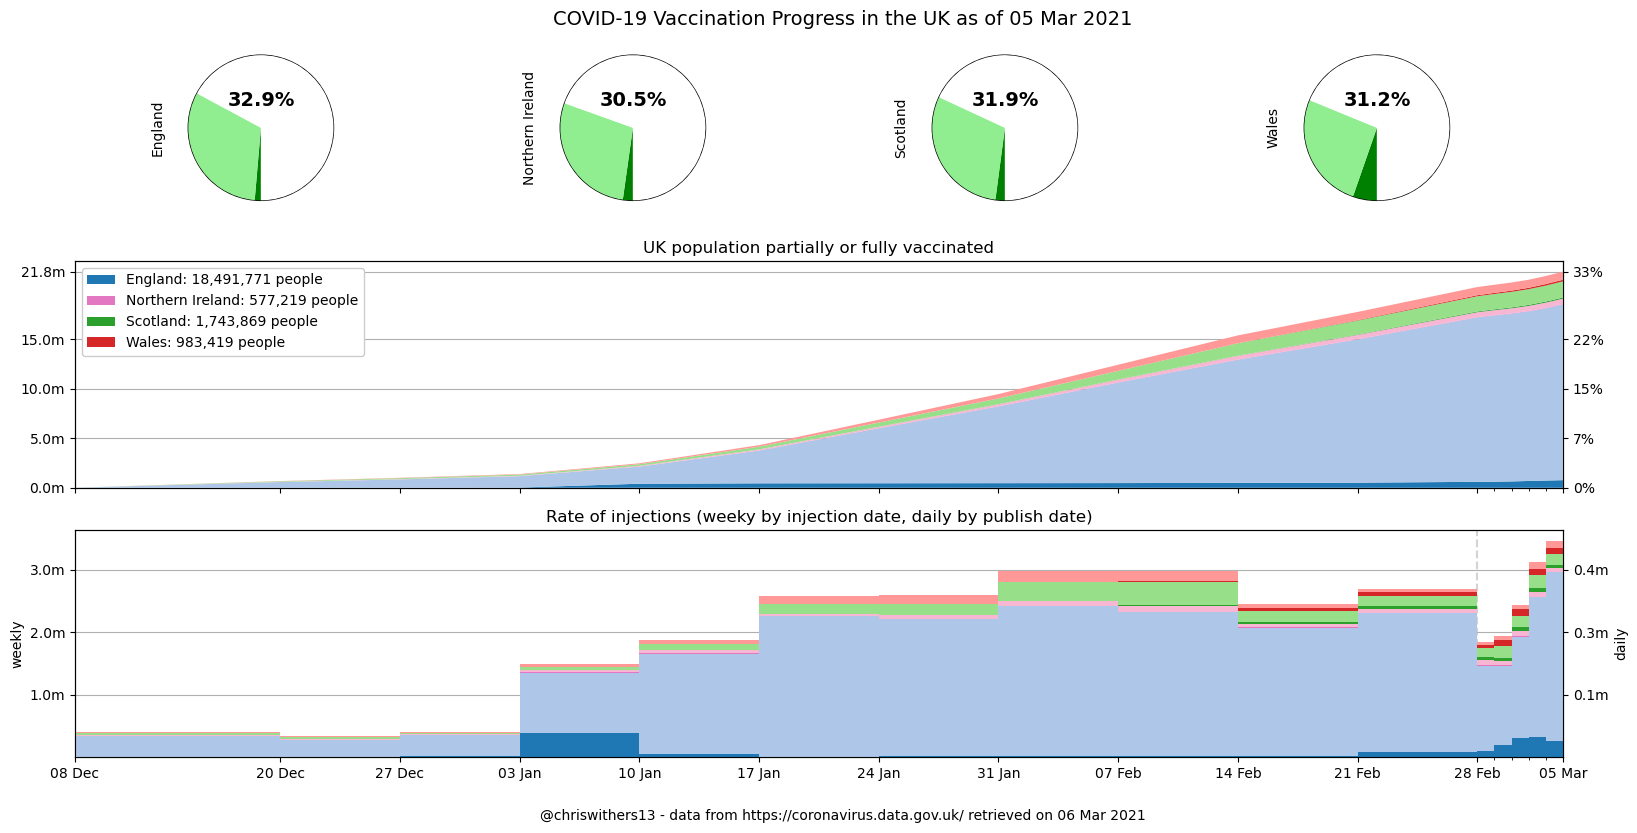

In [4]:
results = vaccination_dashboard(show_partial=True)
display(results, f"partial: {results['any'].sum():,.0f}, full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,05 Mar 21,"+385,681","+37,235","+37,235","+18,491,771","+766,500","+766,500"
Northern Ireland,05 Mar 21,"+9,208",+309,+309,"+577,219","+42,096","+42,096"
Scotland,05 Mar 21,"+26,197","+5,884","+5,884","+1,743,869","+114,081","+114,081"
Wales,05 Mar 21,"+16,377","+13,344","+13,344","+983,419","+168,163","+168,163"


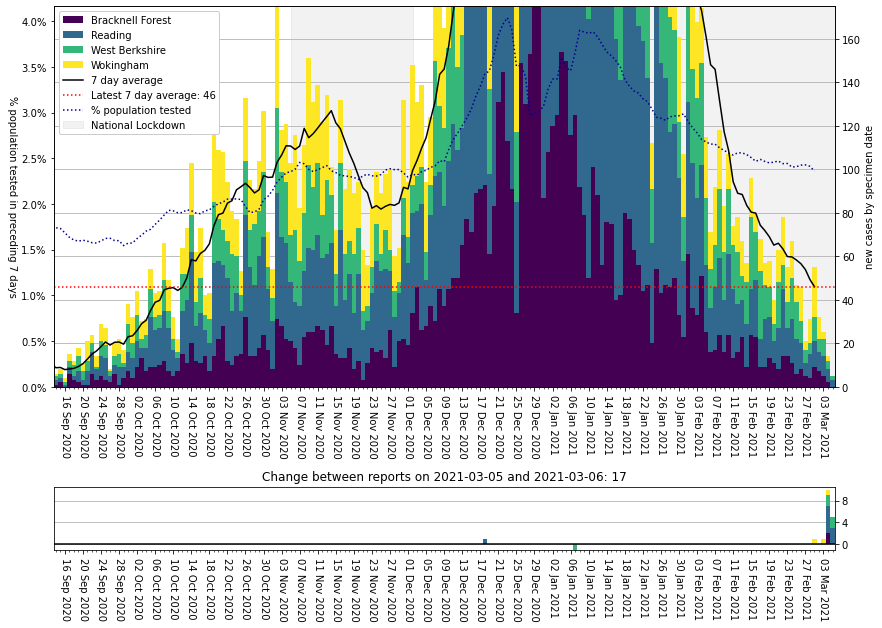

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=175)

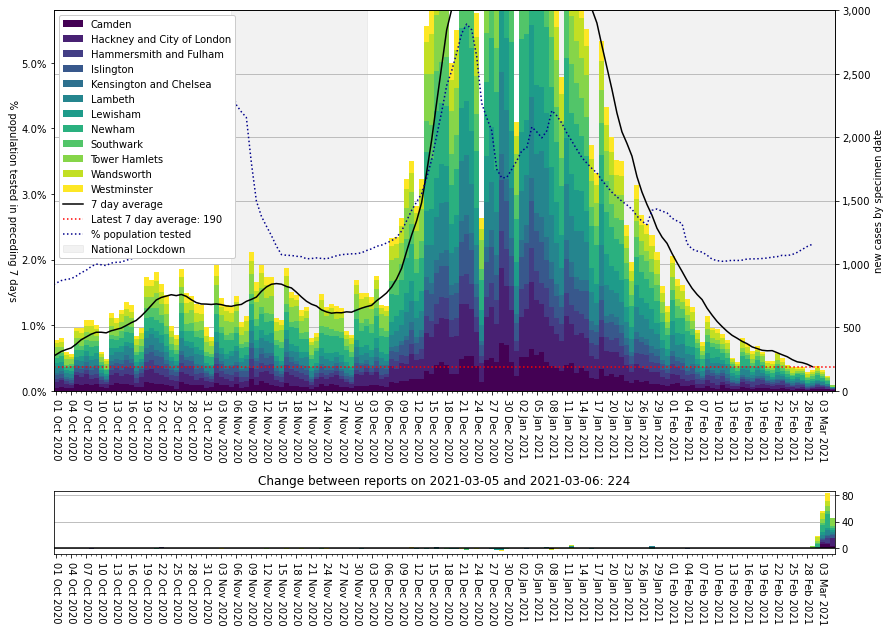

In [7]:
plot_areas(for_date, areas=london_areas, ylim=3_000)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000236,Redditch,139.571434,119.0,2021-03-05
S12000005,Clackmannanshire,135.816841,70.0,2021-03-05
E08000016,Barnsley,129.219901,319.0,2021-03-05
E08000018,Rotherham,128.856754,342.0,2021-03-05
E06000010,"Kingston upon Hull, City of",125.106822,325.0,2021-03-05
E06000031,Peterborough,124.592725,252.0,2021-03-05
E08000032,Bradford,124.125563,670.0,2021-03-05
E07000039,South Derbyshire,123.996606,133.0,2021-03-05
E07000123,Preston,120.166277,172.0,2021-03-05


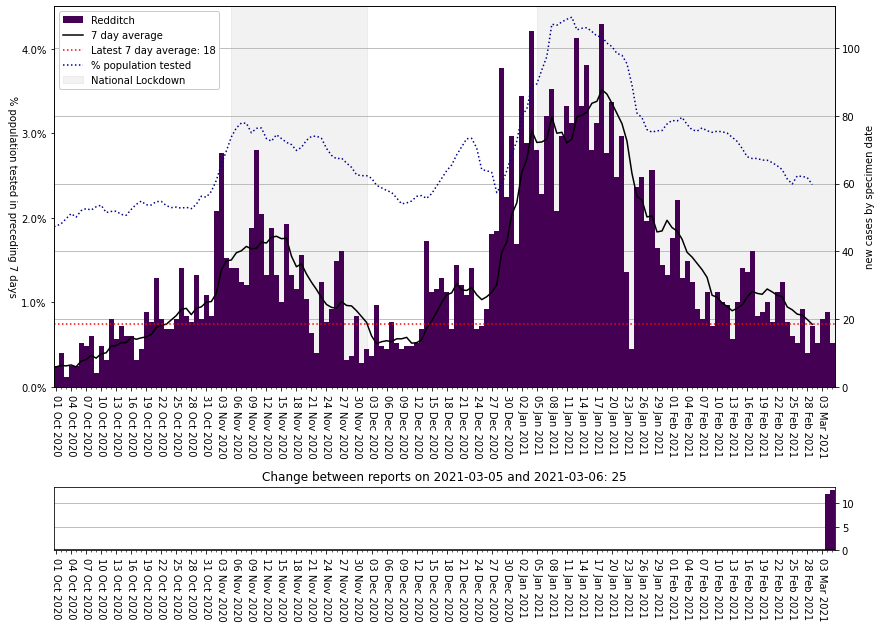

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,77.245371,882.0,2021-03-05
E08000032,Bradford,124.125563,670.0,2021-03-05
E08000035,Leeds,81.448523,646.0,2021-03-05
S12000049,Glasgow City,99.191307,628.0,2021-03-05
E06000016,Leicester,119.415963,423.0,2021-03-05
E08000036,Wakefield,118.858954,414.0,2021-03-05
E08000019,Sheffield,68.906204,403.0,2021-03-05
E08000034,Kirklees,89.816206,395.0,2021-03-05
E06000047,County Durham,74.137794,393.0,2021-03-05


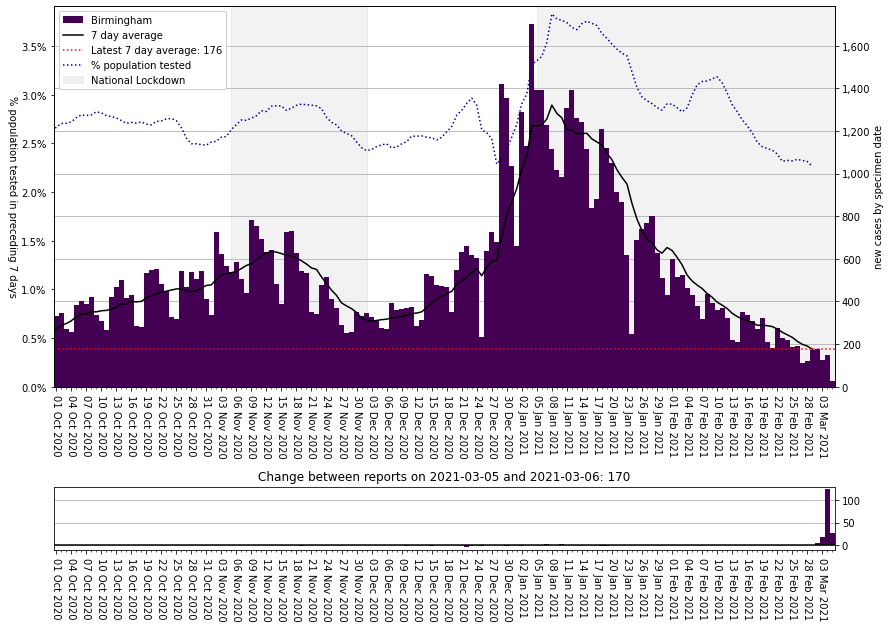

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.3
phe_max = 0.30

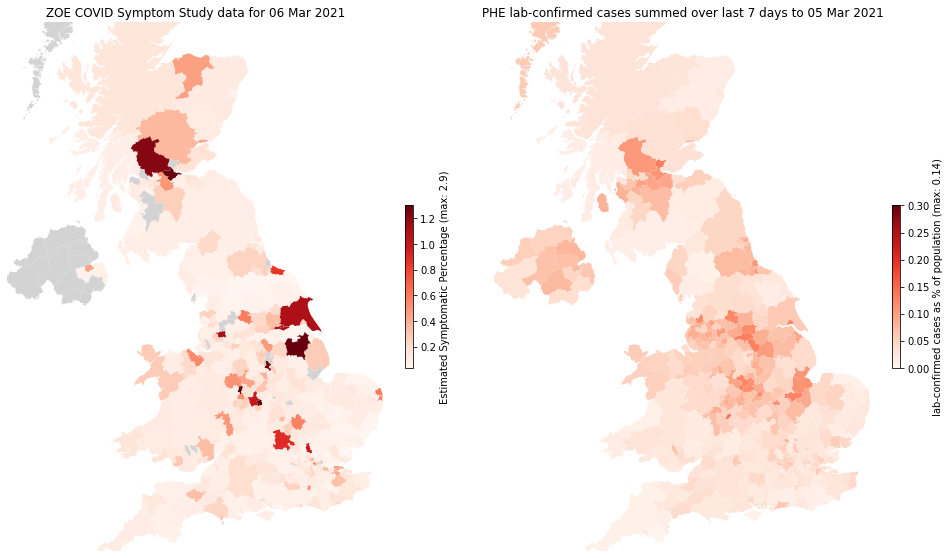

In [14]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [15]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

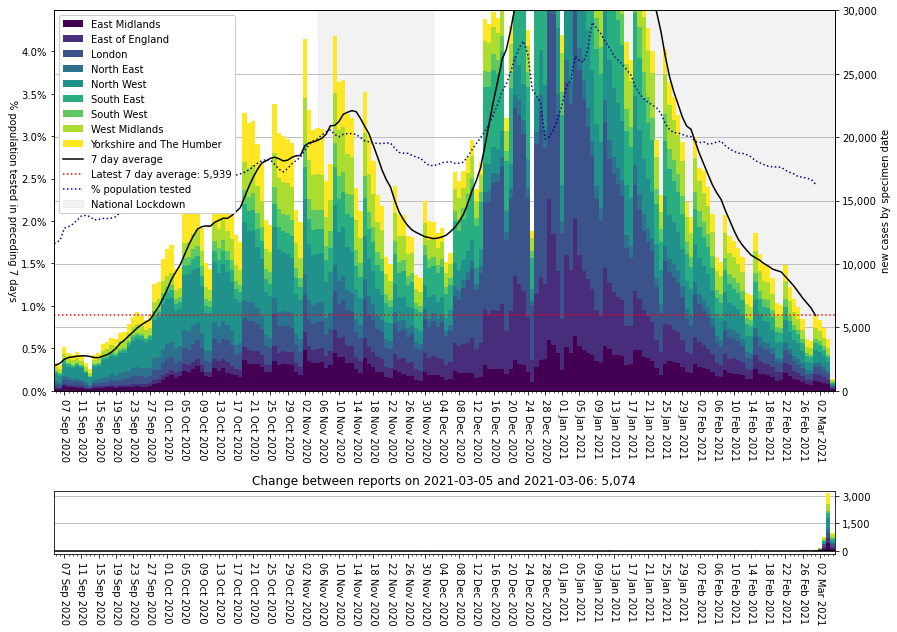

In [16]:
plot_areas(for_date, area_type=region, ylim=30_000, earliest='2020-09-05')

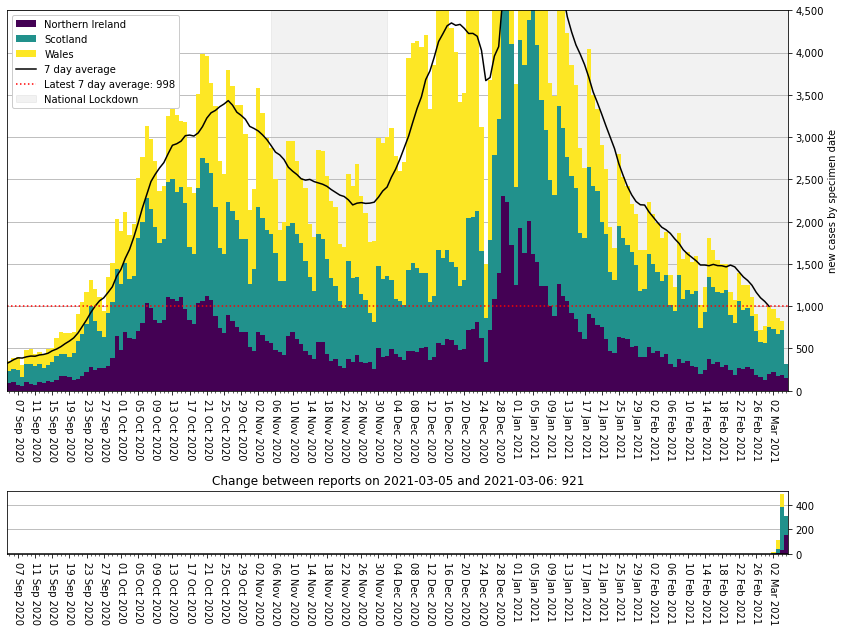

In [17]:
plot_areas(for_date, 'cases_devolved', ylim=4_500, diff_ylims=None, earliest='2020-09-05')